In [1]:
train_data = './data/train'
train_labels = './data/train.csv'
val_data = './data/val'
val_labels = './data/val.csv'

In [2]:
from utilities import GestureDataGenerator, plot_training_history, set_seed, get_callbacks
set_seed(seed=42)

Random seed set to 42


In [3]:
load_fraction = 1.0
batch_size = 64
image_size = (224, 224)

# Initialize the generator
train_generator = GestureDataGenerator(
    data_path=train_data,
    labels_csv=train_labels,
    batch_size=batch_size,
    image_size=image_size,
    augmentations={
        'rotation': 5,       # Rotate up to ±5 degrees
        'brightness': True,  # Random brightness adjustment
        'contrast': True,    # Random contrast adjustment
        'scaling': True,     # Random scaling (zoom)
        'translation': True, # Random translation (shift)
        'blur': True         # Apply Gaussian blur
    },    
    shuffle=True,
    load_fraction=load_fraction,
    debug=False,
    use_mediapipe=False,
    # workers=4,
    # use_multiprocessing=True,
    # max_queue_size=10
)

# # Get the first batch
X, y = train_generator[0]

# # Print outputs
print("Input batch shape (X):", X.shape)  # Expected shape: (batch_size, sequence_length, 224, 224, 3)
print("Labels batch shape (y):", y.shape)  # Expected shape: (batch_size, num_classes)
print("First label in batch (one-hot):", y[0])

val_generator = GestureDataGenerator(
    data_path=val_data,
    labels_csv=val_labels,
    batch_size=batch_size,
    image_size=image_size,
    augmentations=None,
    shuffle=False,
    load_fraction=1.0,
    debug=False,
    use_mediapipe=False,
    # workers=4,
    # use_multiprocessing=True,
    # max_queue_size=10
)

11 batches created, each of size 64, with 663 sequences of 30 images each. Use MediaPipe: False
Input batch shape (X): (64, 30, 224, 224, 3)
Labels batch shape (y): (64, 5)
First label in batch (one-hot): [0. 0. 0. 1. 0.]
2 batches created, each of size 64, with 100 sequences of 30 images each. Use MediaPipe: False


In [4]:
# Define parameters
sequence_length = train_generator.sequence_length  # Frames per video (from generator)
image_size = train_generator.image_size            # Image size (height, width)
num_classes = train_generator.num_classes          # Number of gesture classes
input_shape = (sequence_length, image_size[0], image_size[1], 3)  # input shape

In [5]:
# Updated Pretrained CNN as feature extractor
from tensorflow.keras.applications import MobileNetV2

# Pretrained CNN as feature extractor
cnn_base = MobileNetV2(weights="imagenet", include_top=False, input_shape=(image_size[0], image_size[1], 3))
cnn_base.trainable = False  # Allow fine-tuning of the top layers
cnn_base.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, GRU, Dropout, Dense, MaxPooling2D, Flatten, Input

# Updated model
model = Sequential([
    Input(shape=(30, 224, 224, 3), name="Input_Layer"),       # Input layer for sequences of 30 frames
    TimeDistributed(cnn_base, name="CNN_Layer"),              # CNN base to process each frame independently
    TimeDistributed(MaxPooling2D(), name="MaxPooling_Layer"), # Max Pooling to reduce spatial dimensions
    TimeDistributed(Flatten(), name="Flatten_Layer"),         # Flatten spatial dimensions into feature vectors
    GRU(32, return_sequences=False, name="GRU_Layer"),        # GRU for temporal feature extraction
    Dropout(0.5, name="Dropout_Layer"),                       # Dropout for regularization
    Dense(5, activation="softmax", name="Output_Layer")       # Dense layer for 5 gesture classes
], name="CNN_GRU_Model")

# Compile the model
model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Model summary
model.summary()

Model: "CNN_GRU_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ CNN_Layer (TimeDistributed)     │ (None, 30, 7, 7, 1280) │     2,257,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling_Layer                │ (None, 30, 3, 3, 1280) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten_Layer (TimeDistributed) │ (None, 30, 11520)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU_Layer (GRU)                 │ (None, 32)             │     1,109,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,367,333 (12.85 MB)

 Trainable params: 1,109,349 (4.23 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
model_save_location = 'best-models/pretrained-MobileNetV2+GRU.keras'

In [8]:
checkpoint_callback, reduce_lr_callback, early_stopping_callback = get_callbacks(filepath = model_save_location)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 270s 19s/step - accuracy: 0.2160 - loss: 2.0878 - val_accuracy: 0.2900 - val_loss: 1.5170 - learning_rate: 0.0010
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 189s 17s/step - accuracy: 0.3586 - loss: 1.6036 - val_accuracy: 0.4600 - val_loss: 1.3614 - learning_rate: 0.0010
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 201s 18s/step - accuracy: 0.3748 - loss: 1.5732 - val_accuracy: 0.5300 - val_loss: 1.2501 - learning_rate: 0.0010
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 184s 17s/step - accuracy: 0.4433 - loss: 1.4316 - val_accuracy: 0.5300 - val_loss: 1.2399 - learning_rate: 0.0010
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 187s 17s/step - accuracy: 0.4489 - loss: 1.3168 - val_accuracy: 0.6900 - val_loss: 1.1612 - learning_rate: 0.0010
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 187s 17s/step - accuracy: 0.4427 - loss: 1.3310 - val_accuracy: 0.7200 - val_loss: 1.0793 - learning_rate: 0.0010
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 187s 17s/step - accuracy: 0.5093 - loss: 1.2048 - 

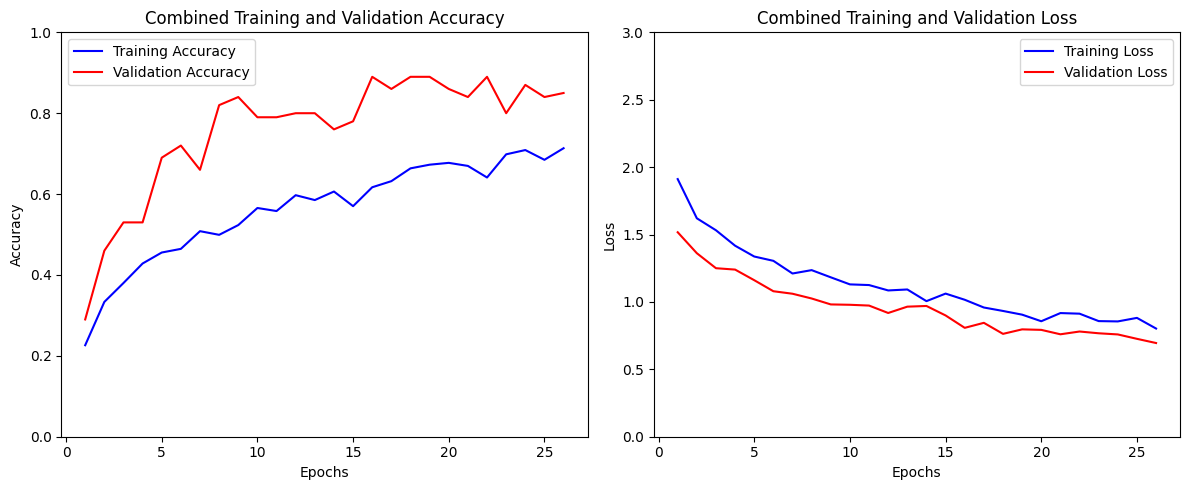

In [9]:
# Train the model
history_1 = model.fit(
    x=train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[checkpoint_callback, reduce_lr_callback, early_stopping_callback],
    verbose=1
)

plot_training_history(histories=[history_1])

In [ ]:
# model.load_weights(model_save_location)

# # Train the model for more epochs
# history_2 = model.fit(
#     x=train_generator,
#     validation_data=val_generator,
#     epochs=50,                   # Train for more epochs
#     initial_epoch=30,            # Start counting previous epochs
#     callbacks=[checkpoint_callback, reduce_lr_callback, early_stopping_callback],
#     verbose=1
# )

# plot_training_history(histories=[history_1, history_2])

In [10]:
model.load_weights(model_save_location)

evaluation_results = model.evaluate(val_generator, verbose=1)

for metric, value in zip(model.metrics_names, evaluation_results):
    print(f"{metric}: {value:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 25s 8s/step - accuracy: 0.9006 - loss: 0.7928
loss: 0.8078
compile_metrics: 0.8900
